In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
from mot.tracker.video_utils import read_folder, split_video
import os
import tensorflow as tf
import multiprocessing
from mot.serving.inference import CPU_COUNT, process_image
from tqdm.notebook import tqdm
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [7]:
dataset_folder = "/srv/data/surfrider/"

In [73]:
video_name = "vid4-1080x1920-far.MP4"
fps = 0.2

In [74]:
def process_video(video_name, fps=fps):
    split_folder = os.path.join(dataset_folder, "rafales_" + video_name + "_" + str(fps))
    if os.path.isdir(split_folder):
        print(split_folder + " exists")
    else:
        split_video(os.path.join(dataset_folder, "videos", video_name),
                split_folder,
                fps)
    image_paths = read_folder(split_folder)
    with multiprocessing.Pool(4) as p:
        inference_outputs = list(
            tqdm(
                p.imap(process_image, image_paths),
                total=len(image_paths),
            )
        )
    return inference_outputs, image_paths

In [75]:
inference_outputs, image_paths = process_video(video_name)

In [76]:
len(image_paths)

16

In [77]:
with open(os.path.join(dataset_folder, "rafales_" + video_name + "_" + str(fps) + ".json"), "w+") as f:
    for image_path, output in zip(image_paths, inference_outputs):
        f.write(json.dumps({"image_path": image_path, "detection": output}) + "\n")

with open(os.path.join(dataset_folder, "rafales_" + video_name + "_" + str(fps) + ".json"), "r") as f:
    lines = [json.loads(line) for line in f]

In [78]:
good_detected = []
min_threshold = 0.3
max_threshold = 0.6
for i, output in enumerate(inference_outputs):
    if output["output/scores:0"] and \
    np.max(np.array(output["output/scores:0"])) > max_threshold:
        good_detected.append(i)

In [79]:
wrong_detected = []
for i, output in enumerate(inference_outputs):
    if output["output/scores:0"] and \
    np.max(np.array(output["output/scores:0"])) > min_threshold and \
    np.max(np.array(output["output/scores:0"])) < max_threshold:
        wrong_detected.append(i)

In [80]:
should_be_detected = []
for i, output in enumerate(inference_outputs):
    if i not in good_detected and ((i+1 in good_detected) or (i-1 in good_detected)):
        should_be_detected.append(i)

In [81]:
def plot(should_be=False):
    idx = 0
    if should_be:
        new_idx = should_be_detected[idx] - 1
    else:
        new_idx = wrong_detected[idx]
    im = Image.open(image_paths[new_idx])
    fig, ax = plt.subplots()
    for i, scores in enumerate(inference_outputs[new_idx]["output/scores:0"]):
        if should_be:
            pass
        else:
            if np.max(np.array(scores)) > min_threshold and np.max(np.array(scores)) < max_threshold:
                box = inference_outputs[new_idx]["output/boxes:0"][i].copy()
                box[0] *= im.size[1]
                box[1] *= im.size[0]
                box[2] *= im.size[1]
                box[3] *= im.size[0]
                ax.add_patch(patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, linewidth=1, color="r"))
    plt.imshow(im)
    inference_outputs[new_idx]

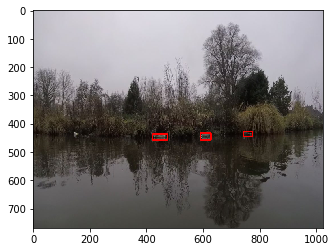

In [82]:
plot(False)

In [83]:
len(good_detected)

7

In [84]:
len(wrong_detected)

4

In [85]:
len(should_be_detected)

4

In [86]:
len(image_paths)

16

In [43]:
with open(os.path.join(dataset_folder, "to_label_" + video_name + ".json"), "w+") as f:
    for i in wrong_detected:
        f.write(json.dumps({"image_path": image_paths[i], 
                            "reason": "threshold between {} and {}".format(min_threshold, max_threshold),
                            }) + "\n")
    for i in should_be_detected:
        f.write(json.dumps({"image_path": image_paths[i], 
                            "reason": "adjacent frame has detection above {}".format(max_threshold),
                            }) + "\n")